Keywords: multi-class classification, Stack Overflow questions, Tagging

# SetUp

In [45]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [46]:
print(tf.__version__)

2.18.0


# Introduction - Sentiment analysis

**multi-class classifier** to predict the **tag of a programming question on Stack Overflow**.

Each of question is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java).

**Objective:** task is to take a question as input, and predict the appropriate tag.

# Download and explore
the IMDB dataset

In [83]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = 'stack_overflow' #os.path.join(dataset, 'stack_overflow')

6053168/6053168 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [87]:
os.listdir(dataset_dir)

['train', 'test', 'README.md']

In [88]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['java', 'csharp', 'javascript', 'python']

In [89]:
sample_file = os.path.join(train_dir, 'java/0.txt')
with open(sample_file) as f:
  print(f.read())

"how to download .msi file in blank i want to download .msi file using blank.  i have tried to download file using following code..printwriter out = null;.fileinputstream filetodownload = null;.bufferedreader bufferedreader = null;.try {.        out = response.getwriter();.        filetodownload = new fileinputstream(download_directory + file_name);.        bufferedreader = new bufferedreader(new inputstreamreader(filetodownload));..        //response.setcontenttype(""application/text"");.        //response.setcontenttype(""application/x-msi"");.        //response.setcontenttype(""application/msi"");.        //response.setcontenttype(""octet-stream"");.        response.setcontenttype(""application/octet-stream"");.        //response.setcontenttype(""application/x-7z-compressed"");.        //response.setcontenttype(""application/zip"");.        response.setheader(""content-disposition"",""attachment; filename="" +file_name );.        response.setcontentlength(filetodownload.available())

# Load Data

load the data off disk and prepare it into a format suitable for training with text_dataset_from_directory function.

In [90]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [91]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Question", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [92]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])



Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [93]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [94]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


# Prepare the dataset for training
we will **standardize, tokenize, and vectorize** the data using the helpful tf.keras.layers.**TextVectorization** layer.

**Standardization** refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.

**Tokenization** refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).

**Vectorization** refers to converting tokens into numbers so they can be fed into a neural network.

we use a custom standardization function to remove the HTML.

To prevent training-testing skew (also known as training-serving skew), it is important to preprocess the data identically at train and test time.

In [95]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

set the output_mode to int to create unique integer indices for each token.

In [96]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

we will call **adapt** to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to **only use your training data** when calling adapt (using the test set would leak information).

In [98]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [99]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [103]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized Question", vectorize_text(first_question, first_label))

Question tf.Tensor(b'"function expected error in blank for dynamically created check box when it is clicked i want to grab the attribute value.it is working in ie 8,9,10 but not working in ie 11,chrome shows function expected error..&lt;input type=checkbox checked=\'checked\' id=\'symptomfailurecodeid\' tabindex=\'54\' style=\'cursor:pointer;\' onclick=chkclickevt(this);  failurecodeid=""1"" &gt;...function chkclickevt(obj) { .    alert(obj.attributes(""failurecodeid""));.}"\n', shape=(), dtype=string)
Label javascript
Vectorized Question (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  38,  450,   65,    7,   16,   12,  892,  265,  186,  451,   44,
          11,    6,  685,    3,   46,    4, 2062,    2,  485,    1,    6,
         158,    7,  479,    1,   26,   20,  158,    7,  479,    1,  502,
          38,  450,    1, 1767, 1763,    1,    1,    1,    1,    1,    1,
           1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0

each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [104]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [105]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

**.cache()** keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

**.prefetch()** overlaps data preprocessing and model execution while training.


In [106]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model
Neural Network

In [107]:
embedding_dim = 16

In [111]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4, activation='sigmoid')])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The layers are stacked sequentially to build the classifier:

The first layer is an **Embedding** layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, check out the Word embeddings tutorial.

Next, a **GlobalAveragePooling1D** layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

The last layer is **densely** connected with a single output node.

# Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use **losses.BinaryCrossentropy** loss function.

Now, configure the model to use an optimizer and a loss function:

In [112]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    ignore_class=None,
    reduction='sum_over_batch_size',
    name='sparse_categorical_crossentropy'
)

model.compile(loss=loss,
              optimizer='adam',
              metrics=['accuracy'])


# Train the model

In [113]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,callbacks=[callback])

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3193 - loss: 1.3794 - val_accuracy: 0.3837 - val_loss: 1.3508
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4242 - loss: 1.3356 - val_accuracy: 0.5569 - val_loss: 1.2865
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5087 - loss: 1.2663 - val_accuracy: 0.6162 - val_loss: 1.1970
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5675 - loss: 1.1787 - val_accuracy: 0.6656 - val_loss: 1.1088
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6251 - loss: 1.0903 - val_accuracy: 0.7013 - val_loss: 1.0276
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6693 - loss: 1.0112 - val_accuracy: 0.7188 - val_loss: 0.9549
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6839 - loss: 0.9447 - val_accuracy: 0.7356 - val_loss: 0.8989
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7152 - loss: 0.8809 - val_accuracy: 0

# Evaluate the model

In [114]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7443 - loss: 0.7946
Loss:  0.799999475479126
Accuracy:  0.7425000071525574


# Create a plot of accuracy and loss over time
model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [115]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

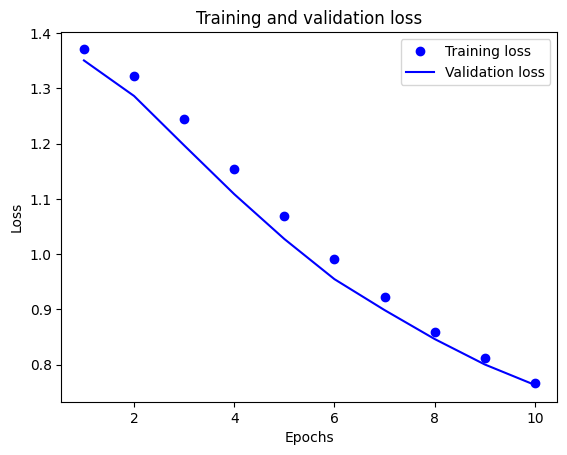

In [116]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

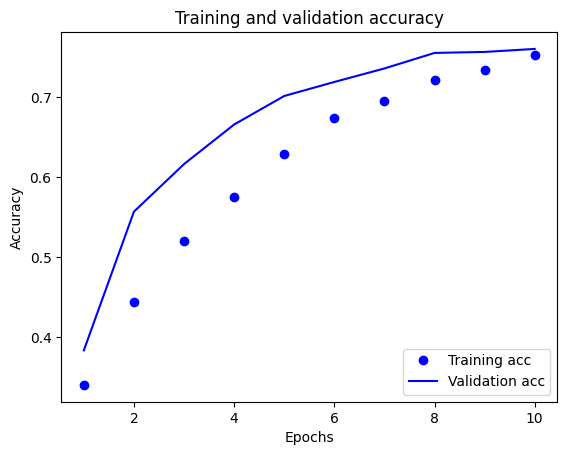

In [118]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the tf.keras.callbacks.**EarlyStopping** callback.

# Export the model

we applied the **TextVectorization** layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [121]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # Changed line
    optimizer="adam",
    metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7431 - loss: 1.1913
{'accuracy': 0.7425000071525574, 'loss': 1.1930842399597168}


# Inference on new data
To get predictions for new examples, you can simply call model.predict().

In [123]:
examples = tf.constant([
  "Removing list duplicates given indices symmetry in python",
  "Infinite carousel gets stuck when scrolling too fast",
  "Java example: Why can a function in this w3schools example run when it is not defined?"
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[0.61228454, 0.61861044, 0.6258049 , 0.628938  ],
       [0.6199184 , 0.6212412 , 0.63622   , 0.610425  ],
       [0.6059407 , 0.6056303 , 0.65477675, 0.61972034]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for train/test skew.

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.